# Modern Pandas (Part 2)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 29-05-2024   | Martin | Created   | Added part 4: performance | 

# Content

* [4. Performance](#4.-performance)
* [5. Tidy Data](#5.-tidy-data)

# 4. Performance

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks')
sns.set_context('talk')
pd.options.display.max_rows = 10

## Constructors

For handling many similar sources (e.g bunch of CSVs) that combine into a single dataframe. 2 methods exist:

1. Intialize one dataframe and append to it
2. Make many small dataframes and combine them at the end _(recommended)_

Option 2 is faster.

Dataframe appends are expensive and depending on the values Pandas might need to recast the data to different types.

In [ ]:
# example of multi-file read
columns = ['station', 'date', 'tmpf', 'relh', 'sped', 'mslp',
           'p01i', 'vsby', 'gust_mph', 'skyc1', 'skyc2', 'skyc3']

files = glob.glob("weather/*.csv")
weather_dfs = [pd.read_csv(fp, names=columns) for fp in files]
weather = pd.concat(weather_dfs)

## Data Types

Numpy's type system with minor extensions:

* `categorical`
* `datetime64` - timezone
* `timedelta64`

Advantage over arrays is that each column can be various dtypes. But a single column should have a single dtype. Mixed dtypes result in the `object` column type, which is slow.

When to have `object` data type:

1. Missing values
2. Dates (outside of `datetime` availability)
3. Text data - strings with no limit. If low cardinality use `categorical`

Always consider the use case of your columns

## Iteration, Apply and Vectorization

Tips for improving performance when working:

1. Benchmark code (refer to bottom for options)
2. Consider the algorithm

In [4]:
df = pd.read_csv("flights_sample_3m.csv")
delays = df['DEP_DELAY']

In [5]:
# Examples of functions that can save time

## Select 5 largest from an array
delays.nlargest(5).sort_values()

## Select 5 smallest from an array
delays.nsmallest(5).sort_values()

1907353   -90.0
2646798   -89.0
2645729   -87.0
670977    -82.0
545959    -74.0
Name: DEP_DELAY, dtype: float64

In [9]:
coord = pd.read_csv("T_MASTER_CORD.csv", usecols=['AIRPORT', 'LATITUDE', 'LONGITUDE'], index_col=['AIRPORT']) \
  .groupby(level=0).first() \
  .dropna() \
  .sample(n=500) \
  .sort_index()
coord.head()

,LATITUDE,LONGITUDE
AIRPORT,,
05A,67.570000,-148.183889
06A,57.745278,-152.882778
07A,55.554722,-133.101667
2NY,40.827500,-73.716944
5GA,34.455278,-84.939167


In [10]:
# Find the pairwise distance between airports

## 1. Get a double index - use MultiIndex.from_product to get cartesian product
idx = pd.MultiIndex.from_product(
  [coord.index, coord.index],
  names=['origin', 'dest']
)
pairs = pd.concat([
  coord.add_suffix('_1').reindex(idx, level='origin'),
  coord.add_suffix('_2').reindex(idx, level='dest')
], axis=1)
pairs.head()

LATITUDE_1  LONGITUDE_1  LATITUDE_2  LONGITUDE_2
origin dest                                                  
05A    05A        67.57  -148.183889   67.570000  -148.183889
       06A        67.57  -148.183889   57.745278  -152.882778
       07A        67.57  -148.183889   55.554722  -133.101667
       2NY        67.57  -148.183889   40.827500   -73.716944
       5GA        67.57  -148.183889   34.455278   -84.939167

In [28]:
import math

def gcd_py(lat1, lng1, lat2, lng2):
  '''
  Calculate great circle distance between two points.
  http://www.johndcook.com/blog/python_longitude_latitude/
  
  Parameters
  ----------
  lat1, lng1, lat2, lng2: float
  
  Returns
  -------
  distance:
    distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
  '''
  # python2 users will have to use ascii identifiers (or upgrade)
  degrees_to_radians = math.pi / 180.0
  ϕ1 = (90 - lat1) * degrees_to_radians
  ϕ2 = (90 - lat2) * degrees_to_radians
  
  θ1 = lng1 * degrees_to_radians
  θ2 = lng2 * degrees_to_radians
  
  cos = (math.sin(ϕ1) * math.sin(ϕ2) * math.cos(θ1 - θ2) +
          math.cos(ϕ1) * math.cos(ϕ2))
  # round to avoid precision issues on identical points causing ValueErrors
  cos = round(cos, 8)
  arc = math.acos(cos)
  return arc * 6373  # radius of earth, in kilometers

def gcd_vec(lat1, lng1, lat2, lng2):
  '''
  Calculate great circle distance.
  http://www.johndcook.com/blog/python_longitude_latitude/
  
  Parameters
  ----------
  lat1, lng1, lat2, lng2: float or array of float
  
  Returns
  -------
  distance:
    distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
  '''
  # python2 users will have to use ascii identifiers
  ϕ1 = np.deg2rad(90 - lat1)
  ϕ2 = np.deg2rad(90 - lat2)
  
  θ1 = np.deg2rad(lng1)
  θ2 = np.deg2rad(lng2)
  
  cos = (np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) +
          np.cos(ϕ1) * np.cos(ϕ2))
  arc = np.arccos(cos)
  return arc * 6373

In [ ]:
%%time
r = gcd_vec(pairs['LATITUDE_1'], pairs['LONGITUDE_1'],
            pairs['LATITUDE_2'], pairs['LONGITUDE_2'])

In [ ]:
%%time
r = pairs.apply(lambda x: gcd_py(x['LATITUDE_1'], x['LONGITUDE_1'],
                                 x['LATITUDE_2'], x['LONGITUDE_2']), axis=1)

GroupBy objects intercept calls for common functions and substitutes them with optimized Cython versions i.e `.transform(np.mean)` and `.transform(np.std)` is faster than `.apply(lambda x: x - x.mean()/x.std())`

In [2]:
import random
import pandas as pd
import numpy as np

def create_frame(n, n_groups):
    # just setup code, not benchmarking this
    stamps = pd.date_range('20010101', periods=n, freq='ms')
    random.shuffle(stamps.values)    
    return pd.DataFrame({'name': np.random.randint(0,n_groups,size=n),
                         'stamp': stamps,
                         'value': np.random.randint(0,n,size=n),
                         'value2': np.random.randn(n)})
df = create_frame(1000000,10000)                        

In [4]:
def f_unwrap(df):
    # "unwrapped"
    g = df.groupby('name').value2
    v = df.value2
    return (v-g.transform(np.mean))/g.transform(np.std)

## Categoricals

Efficient way to represent string data that have low cardinality

Categoricals stores the categories once, and an array of `codes` that are integers that indicate which category it belongs to

In [ ]:
import string

# As Strings
s = pd.Series(np.random.choice(list(string.ascii_letters), 100000))
print('{:0.2f} KB'.format(s.memory_usage(index=False) / 1000))

# As Categoricals
c = s.astype('category')
print('{:0.2f} KB'.format(c.memory_usage(index=False) / 1000))

---

# 5. Tidy Data

Before performing any EDA, tidy up data. These constitutes tidy data:

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observation unit forms a table

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

In [23]:
# Getting data
fp = 'nba.csv'

if not os.path.exists(fp):
    tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
    games.index = games['Unnamed: 0']
    games.index.name = None
    games = games.drop('Unnamed: 0', axis=1)
games.head()

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Arena,Notes
0,"Tue, Oct 27, 2015",8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,United Center,NaN
1,"Tue, Oct 27, 2015",8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,Philips Arena,NaN
2,"Tue, Oct 27, 2015",10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,Oracle Arena,NaN
3,"Wed, Oct 28, 2015",7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,Amway Center,NaN
4,"Wed, Oct 28, 2015",7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,TD Garden,NaN


Goal: Calculate the number of days of rest NBA teams have between games

In [24]:
column_names = {
  'Date': 'date',
  'Start (ET)': 'start',
  'Unamed: 2': 'box',
  'Visitor/Neutral': 'away_team',
  'PTS': 'away_points',
  'Home/Neutral': 'home_team',
  'PTS.1': 'home_points',
  'Unamed: 7': 'n_ot'
}

# Perform transformations
games = games.rename(columns=column_names) \
  .dropna(thresh=4)[['date', 'away_team', 'away_points', 'home_team', 'home_points']] \
  .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y')) \
  .set_index('date', append=True) \
  .rename_axis(['game_id', 'date']) \
  .sort_index()
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Washington Wizards,88,Orlando Magic,87
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112


What constitutes an observation in this question - An observation is a `(team, game)` combination i.e `("Cleveland Cavaliers", "game on 2015-10-27")`

Therefore, the current data is not tidy since it has 2 observations per row

In [25]:
tidy = pd.melt(
  games.reset_index(),
  id_vars=['game_id', 'date'],
  value_vars=['away_team', 'home_team'],
  value_name='team'
)
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Cleveland Cavaliers
1,1,2015-10-27,away_team,Detroit Pistons
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Washington Wizards
4,4,2015-10-28,away_team,Philadelphia 76ers


In [26]:
# Answering the question
# groupby team name get the difference in date between the previous match
tidy.groupby('team')['date'].diff().dt.days - 1

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    0.0
72    2.0
73    2.0
74    2.0
75    1.0
Name: date, Length: 76, dtype: float64

In [33]:
tidy['rest'] = tidy.groupby('team')['date'].diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
11,11,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
19,19,2015-10-29,away_team,Dallas Mavericks,0.0
21,21,2015-10-30,away_team,Utah Jazz,1.0
24,24,2015-10-30,away_team,Chicago Bulls,1.0


In [ ]:
# Match the home_rest and away_rest times into the original matchup dates
by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'],
                          columns='variable')
             .rename(columns={'away_team': 'away_rest',
                              'home_team': 'home_rest'}))
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

### Stack / Unstack

Converting dataframes between long and wide formats.

* `stack` - wide to long
* `unstack` - long to wide

In [35]:
# Currently in long format
rest = tidy.groupby(['date', 'variable'])['rest'] \
  .mean() \
  .dropna()

rest.head()

date        variable 
2015-10-27  home_team   -4.0
2015-10-28  away_team    0.0
            home_team   -2.9
2015-10-29  away_team    0.0
            home_team   -1.0
Name: rest, dtype: float64

In [36]:
# Long -> Wide
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-27,NaN,-4.000000
2015-10-28,0.0,-2.900000
2015-10-29,0.0,-1.000000
2015-10-30,1.0,1.083333
2015-10-31,0.5,1.333333


In [37]:
# Wide -> Long
rest.unstack().stack().head()

date        variable 
2015-10-27  home_team   -4.0
2015-10-28  away_team    0.0
            home_team   -2.9
2015-10-29  away_team    0.0
            home_team   -1.0
dtype: float64

This is good for moving between APIs that use the wide or long formats

E.g `DataFrame.plot()` that uses the wide format - 1 column = 1 line

In [40]:
rest

date        variable 
2015-10-27  home_team   -4.000000
2015-10-28  away_team    0.000000
            home_team   -2.900000
2015-10-29  away_team    0.000000
            home_team   -1.000000
2015-10-30  away_team    1.000000
            home_team    1.083333
2015-10-31  away_team    0.500000
            home_team    1.333333
Name: rest, dtype: float64

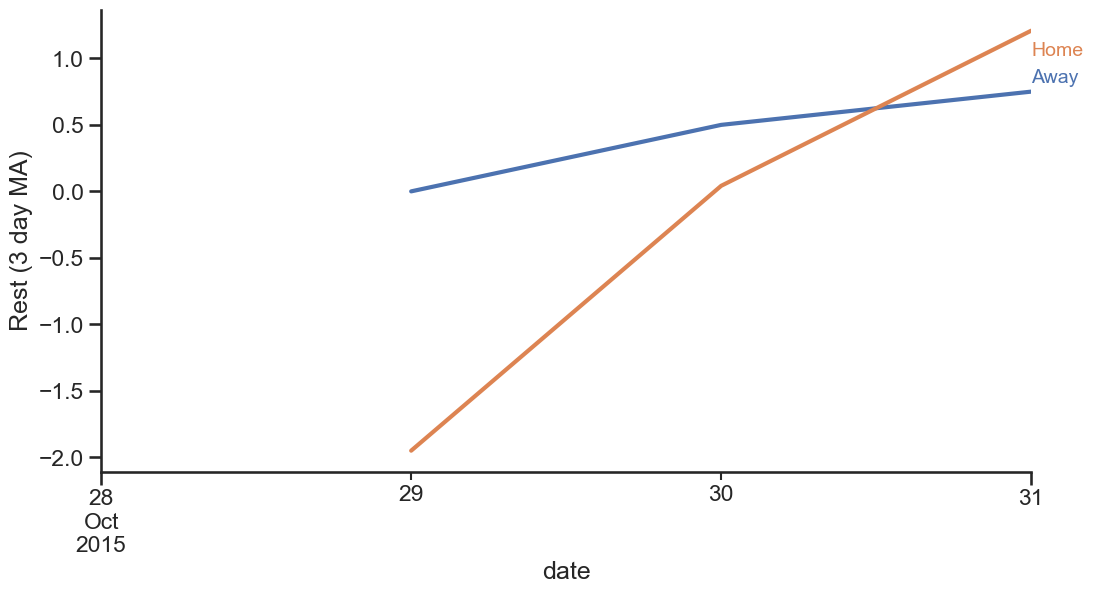

In [43]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 3')
        .rolling(2)
        .mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (3 day MA)')
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()

# References

On performance measuring:

* https://github.com/nvdv/vprof
* https://jiffyclub.github.io/snakeviz/
* https://github.com/rkern/line_profiler